<a href="https://colab.research.google.com/github/sonalshreya25/respiratoryDiagnostic/blob/main/ICBHI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ✅ STEP 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# ✅ STEP 1: Set Paths
import os
import pandas as pd
from glob import glob
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Change this to your Google Drive path
root_dir = "/content/drive/MyDrive/ICBHI_final_database"
audio_dir = os.path.join(root_dir, "recordings_annotations")
diagnosis_file = os.path.join(root_dir, "diagnosis_data.txt")
train_patients_file = os.path.join(root_dir, "train_data.txt")
test_patients_file = os.path.join(root_dir, "test_data.txt")
train_test_file = os.path.join(root_dir, "train_test_data.txt")
events_folder = os.path.join(root_dir, "events/events")


In [7]:
# ✅ STEP 2: Load diagnosis and patient split data
diagnosis_df = pd.read_csv(diagnosis_file, header=None, sep='\t', names=['Patient_ID', 'Diagnosis'])
diagnosis_df['Patient_ID'] = diagnosis_df['Patient_ID'].astype(str)

with open(train_patients_file, 'r') as f:
    train_patients = [line.strip() for line in f.readlines()]

with open(test_patients_file, 'r') as f:
    test_patients = [line.strip() for line in f.readlines()]


In [8]:
# ✅ STEP 3: Scan all audio + annotation files
data = []

for wav_file in tqdm(glob(os.path.join(audio_dir, "*.wav"))):
    base_name = os.path.basename(wav_file)
    patient_id = base_name.split('_')[0]
    txt_file = wav_file.replace(".wav", ".txt")

    if not os.path.exists(txt_file):
        continue

    diagnosis = diagnosis_df.loc[diagnosis_df['Patient_ID'] == patient_id, 'Diagnosis']
    diagnosis = diagnosis.values[0] if not diagnosis.empty else None

    if patient_id in train_patients:
        split = 'train'
    elif patient_id in test_patients:
        split = 'test'
    else:
        split = 'unknown'

    data.append({
        'Patient_ID': patient_id,
        'File': base_name,
        'WAV_Path': wav_file,
        'TXT_Path': txt_file,
        'Diagnosis': diagnosis,
        'Split': split
    })

df = pd.DataFrame(data)


100%|██████████| 920/920 [00:00<00:00, 1505.13it/s]


In [9]:
# ✅ STEP 4: Extract crackle and wheeze events from event files
def extract_events(file_name):
    base_name = os.path.splitext(file_name)[0]
    events_file = os.path.join(events_folder, base_name + '_events.txt')
    has_crackle, has_wheeze = 0, 0
    try:
        with open(events_file, 'r') as f:
            for line in f:
                if 'crackle' in line.lower():
                    has_crackle = 1
                if 'wheeze' in line.lower():
                    has_wheeze = 1
    except FileNotFoundError:
        pass
    return pd.Series([has_crackle, has_wheeze])

df[['Crackles', 'Wheezes']] = df['File'].apply(extract_events)


In [10]:
# ✅ STEP 5: Merge refined train/test data from shared file
split_df = pd.read_csv(
    train_test_file,
    sep='\t',
    header=None,
    names=['FileBase', 'Split']
)
split_df['File'] = split_df['FileBase'] + '.wav'
split_df.drop(columns='FileBase', inplace=True)

df = df.drop(columns=['Split'])  # Remove old one
df = df.merge(split_df, on='File', how='left')
df['Split'] = df['Split'].fillna('unknown')


In [11]:
# ✅ STEP 6: Display the final DataFrame
print("✅ Final DataFrame shape:", df.shape)
df.head()


✅ Final DataFrame shape: (920, 8)


,Patient_ID,File,WAV_Path,TXT_Path,Diagnosis,Crackles,Wheezes,Split
0,160,160_1b3_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,test
1,160,160_1b4_Ar_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
2,158,158_1p4_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,train
3,160,160_1b3_Al_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
4,159,159_1b1_Ll_sc_Meditron.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,Healthy,0,0,train


In [12]:
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Create output folder
output_dir = os.path.join(root_dir, "spectrograms")
os.makedirs(output_dir, exist_ok=True)

# Spectrogram helper
def generate_and_save_spectrogram(wav_path, file_name, duration=3, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # STFT + dB conversion
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Normalize for training (.npy)
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # Save .npy
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # Save .png
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return npy_path, png_path


In [13]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    npy_path = os.path.join(output_dir, row['File'].replace('.wav', '.npy'))
    png_path = os.path.join(output_dir, row['File'].replace('.wav', '.png'))

    # Skip if both files already exist
    if os.path.exists(npy_path) and os.path.exists(png_path):
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
        continue

    try:
        npy_path, png_path = generate_and_save_spectrogram(row['WAV_Path'], row['File'])
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
    except Exception as e:
        print(f"⚠️ Failed to process {row['File']}: {e}")


100%|██████████| 920/920 [00:06<00:00, 141.62it/s]


In [14]:
df.to_pickle(os.path.join(root_dir, "df_with_spectrograms.pkl"))
print("✅ Saved metadata with spectrogram paths.")


✅ Saved metadata with spectrogram paths.


✅ Total valid samples after filtering: 919
🔠 Encoded Classes: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


<ipython-input-15-5c573f278746>:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


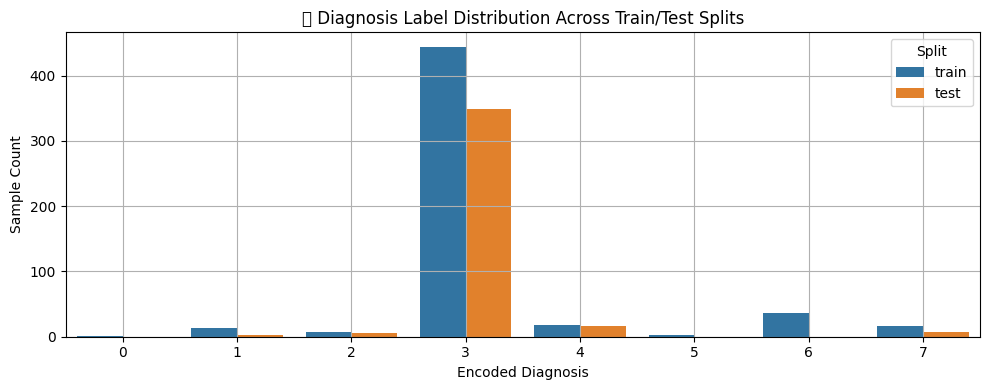

In [15]:
# ✅ Skip 'unknown' patients
df = df[df['Split'].isin(['train', 'test'])].reset_index(drop=True)
print(f"✅ Total valid samples after filtering: {df.shape[0]}")

# ✅ Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Diagnosis'].astype(str))

# 🔍 Show label mapping
print("🔠 Encoded Classes:", list(label_encoder.classes_))
num_classes = len(label_encoder.classes_)

# ✅ Visualize label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.countplot(x='EncodedLabel', hue='Split', data=df)
plt.title("🔍 Diagnosis Label Distribution Across Train/Test Splits")
plt.xlabel("Encoded Diagnosis")
plt.ylabel("Sample Count")
plt.legend(title='Split')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# ✅ Split into train/test DataFrames
train_df = df[df['Split'] == 'train'].reset_index(drop=True)
test_df = df[df['Split'] == 'test'].reset_index(drop=True)

# ✅ Save to .pkl for reproducibility
train_split_path = os.path.join(root_dir, "train_split.pkl")
test_split_path = os.path.join(root_dir, "test_split.pkl")

train_df.to_pickle(train_split_path)
test_df.to_pickle(test_split_path)

print(f"📁 Train split saved to: {train_split_path}")
print(f"📁 Test split saved to: {test_split_path}")


📁 Train split saved to: /content/drive/MyDrive/ICBHI_final_database/train_split.pkl
📁 Test split saved to: /content/drive/MyDrive/ICBHI_final_database/test_split.pkl


In [17]:
# 🔄 Reload split data
train_df = pd.read_pickle(train_split_path)
test_df = pd.read_pickle(test_split_path)

print(f"🧪 Reloaded: Train shape {train_df.shape}, Test shape {test_df.shape}")


🧪 Reloaded: Train shape (538, 11), Test shape (381, 11)


In [46]:
valid_indices = []

for i in range(len(train_df)):
    try:
        spec = np.load(train_df.loc[i, 'Spectrogram_Array'])
        if spec.shape[0] == 1025:  # Expected freq bins
            valid_indices.append(i)
    except:
        continue

train_df = train_df.loc[valid_indices].reset_index(drop=True)
print(f"✅ Filtered train set: {len(train_df)} samples")

valid_indices = []
for i in range(len(test_df)):
    try:
        spec = np.load(test_df.loc[i, 'Spectrogram_Array'])
        if spec.shape[0] == 1025:
            valid_indices.append(i)
    except:
        continue

test_df = test_df.loc[valid_indices].reset_index(drop=True)
print(f"✅ Filtered test set: {len(test_df)} samples")


✅ Filtered train set: 538 samples
✅ Filtered test set: 381 samples


In [67]:
# ✅ Dataset class that guarantees fixed shape [1025, 256]
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ICBHI_1D_CNN_Dataset(Dataset):
    def __init__(self, df_subset, max_len=256, expected_freq=1025):
        self.data = df_subset.reset_index(drop=True)
        self.max_len = max_len
        self.expected_freq = expected_freq

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx]
        try:
            spectrogram = np.load(row['Spectrogram_Array'])  # [freq, time]
        except:
            spectrogram = np.zeros((self.expected_freq, self.max_len))

        if len(spectrogram.shape) != 2:
            spectrogram = np.zeros((self.expected_freq, self.max_len))

        freq, time = spectrogram.shape

        # Pad/truncate freq axis
        if freq < self.expected_freq:
            spectrogram = np.pad(spectrogram, ((0, self.expected_freq - freq), (0, 0)), mode='constant')
        elif freq > self.expected_freq:
            spectrogram = spectrogram[:self.expected_freq, :]

        # Pad/truncate time axis
        if time < self.max_len:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, self.max_len - time)), mode='constant')
        elif time > self.max_len:
            spectrogram = spectrogram[:, :self.max_len]

        x = torch.tensor(spectrogram, dtype=torch.float32)
        y = torch.tensor(row['EncodedLabel'], dtype=torch.long)
        return x, y


In [68]:
# ✅ Build datasets and dataloaders
train_ds = ICBHI_1D_CNN_Dataset(train_df, max_len=256)
test_ds = ICBHI_1D_CNN_Dataset(test_df, max_len=256)

# Quick sanity check
x0, y0 = train_ds[0]
print("🧪 Example shape:", x0.shape)  # should be [1025, 256]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)
print("✅ Dataloaders ready")




🧪 Example shape: torch.Size([1025, 256])
✅ Dataloaders ready


In [69]:
# ✅ Define ResNet1D model
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 1, stride=stride),
            nn.BatchNorm1d(out_channels)
        ) if downsample or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer1 = ResidualBlock1D(in_channels, 32)
        self.layer2 = ResidualBlock1D(32, 64, downsample=True)
        self.layer3 = ResidualBlock1D(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


In [70]:
# ✅ Train the model
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['EncodedLabel'].unique())
input_channels = x0.shape[0]

model = ResNet1D(input_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"📚 Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")


📚 Epoch 1 | Loss: 16.7184 | Accuracy: 0.9160
📚 Epoch 2 | Loss: 8.6572 | Accuracy: 0.9160
📚 Epoch 3 | Loss: 7.1651 | Accuracy: 0.9213
📚 Epoch 4 | Loss: 6.3591 | Accuracy: 0.9265
📚 Epoch 5 | Loss: 6.3278 | Accuracy: 0.9160
📚 Epoch 6 | Loss: 6.2688 | Accuracy: 0.8661
📚 Epoch 7 | Loss: 5.9245 | Accuracy: 0.7822
📚 Epoch 8 | Loss: 5.2613 | Accuracy: 0.9134
📚 Epoch 9 | Loss: 5.1681 | Accuracy: 0.9291
📚 Epoch 10 | Loss: 4.9167 | Accuracy: 0.9239


In [71]:
torch.save(model.state_dict(), "resnet1d_icbhi.pth")


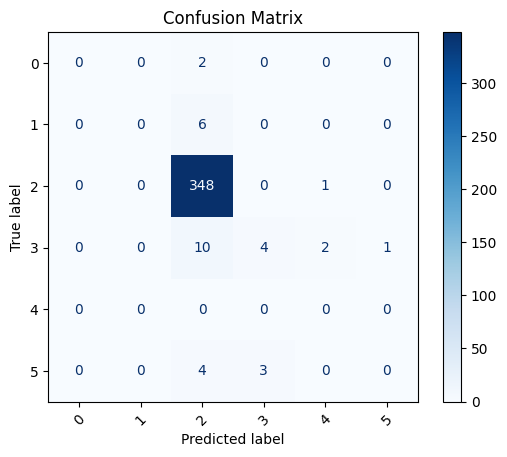

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()



In [75]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_df['Spectrogram_Array'].values
y = train_df['EncodedLabel'].values

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🌀 Fold {fold+1}")

    fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_ds = ICBHI_1D_CNN_Dataset(fold_train_df)
    val_ds = ICBHI_1D_CNN_Dataset(fold_val_df)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    # 🔁 Train your model on fold_train_df and validate on val_loader...



🌀 Fold 1

🌀 Fold 2

🌀 Fold 3

🌀 Fold 4

🌀 Fold 5


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


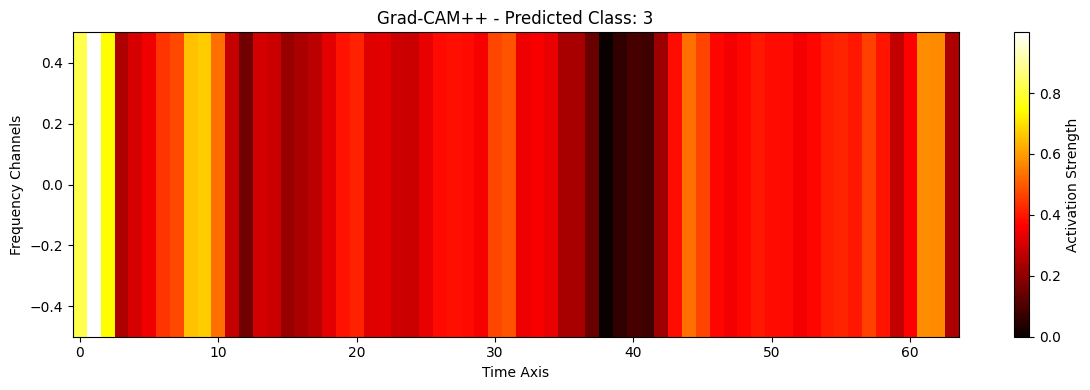

In [79]:
# Get input
input_tensor, label = train_ds[0]
input_tensor = input_tensor.unsqueeze(0).to(device)

# Grad-CAM++ setup
from torchcam.methods import GradCAMpp
cam_extractor = GradCAMpp(model, target_layer="layer3")

# Forward pass (❌ no torch.no_grad())
model.eval()
output = model(input_tensor)

# Get activation map
predicted_class = output.argmax(dim=1).item()
activation_map = cam_extractor(predicted_class, output)[0].cpu()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.imshow(activation_map, aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label="Activation Strength")
plt.title(f"Grad-CAM++ - Predicted Class: {predicted_class}")
plt.xlabel("Time Axis")
plt.ylabel("Frequency Channels")
plt.tight_layout()
plt.show()


In [80]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchcam.methods import GradCAMpp

# 📁 Create directory to save Grad-CAM++ visual outputs
save_dir = "gradcam_outputs"
os.makedirs(save_dir, exist_ok=True)

# 🎯 Set up Grad-CAM++ extractor on the final conv layer
cam_extractor = GradCAMpp(model, target_layer="layer3")
model.eval()

# 🔁 Loop over first N samples from the dataset
N = 5  # Change this to however many samples you want
for idx in range(N):
    # Load one sample
    input_tensor, label = train_ds[idx]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dim

    # Forward pass
    output = model(input_tensor)

    # Predicted class
    predicted_class = output.argmax(dim=1).item()

    # Get activation map
    activation_map = cam_extractor(predicted_class, output)[0].cpu().numpy()

    # Original spectrogram
    original_spec = input_tensor.squeeze(0).cpu().numpy()

    # Normalize activation map
    act_resized = np.interp(activation_map, (activation_map.min(), activation_map.max()), (0, 1))

    # 🔍 Plot: Overlay CAM on spectrogram
    plt.figure(figsize=(12, 4))
    plt.imshow(original_spec, aspect='auto', origin='lower', cmap='gray')
    plt.imshow(act_resized, aspect='auto', origin='lower', cmap='hot', alpha=0.4)
    plt.colorbar(label="Activation Strength")
    plt.title(f"Grad-CAM++ Overlay | Pred: {predicted_class} | True: {label}")
    plt.xlabel("Time Axis")
    plt.ylabel("Frequency Channels")
    plt.tight_layout()

    # 💾 Save the figure
    out_path = os.path.join(save_dir, f"gradcam_{idx}_pred{predicted_class}_true{label}.png")
    plt.savefig(out_path)
    plt.close()

print(f"✅ Saved Grad-CAM++ overlays for {N} samples to: {save_dir}")


✅ Saved Grad-CAM++ overlays for 5 samples to: gradcam_outputs


In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchcam.methods import GradCAMpp
from PIL import Image

# 🎯 Grad-CAM++ setup
cam_extractor = GradCAMpp(model, target_layer="layer3")
model.eval()

# 📁 Output folders
correct_dir = "gradcam_correct"
incorrect_dir = "gradcam_incorrect"
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# 🔁 Loop through training set
N = 20  # You can increase this
for idx in range(N):
    # Load spectrogram from Dataset
    input_tensor, label = train_ds[idx]
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Predict and extract attention
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()

    # Locate corresponding PNG file
    npy_path = train_df.loc[idx, 'Spectrogram_Array']
    png_path = npy_path.replace(".npy", ".png")
    if not os.path.exists(png_path):
        print(f"❌ Missing PNG: {png_path}")
        continue

    # Load image and overlay attention
    spec_img = Image.open(png_path).convert("RGB")
    spec_array = np.array(spec_img)

    # Normalize and resize activation map
    activation_map_resized = np.interp(activation_map, (activation_map.min(), activation_map.max()), (0, 1))
    heatmap = plt.cm.jet(activation_map_resized)[:, :, :3]  # RGB colormap
    heatmap_img = Image.fromarray(np.uint8(heatmap * 255)).resize(spec_img.size)

    # Blend with original
    overlay = Image.blend(spec_img, heatmap_img, alpha=0.5)

    # 📸 Side-by-side comparison
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].imshow(spec_img)
    axs[0].set_title("Original Spectrogram")
    axs[0].axis("off")

    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM++ Overlay | Pred: {pred_class} | True: {label}")
    axs[1].axis("off")

    # Save to correct/incorrect folders
    plt.tight_layout()
    folder = correct_dir if pred_class == label else incorrect_dir
    out_path = os.path.join(folder, f"cam_{idx}_pred{pred_class}_true{label}.png")
    plt.savefig(out_path)
    plt.close()

print(f"✅ All Grad-CAM++ overlays saved to '{correct_dir}' and '{incorrect_dir}'")
# Google Drive path (change this to any folder you want inside your Drive)
base_dir = "/content/drive/MyDrive/ICBHI_GradCAM"

correct_dir = os.path.join(base_dir, "gradcam_correct")
incorrect_dir = os.path.join(base_dir, "gradcam_incorrect")

os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)
!zip -r /content/drive/MyDrive/ICBHI_GradCAM_correct.zip /content/drive/MyDrive/ICBHI_GradCAM/gradcam_correct
!zip -r /content/drive/MyDrive/ICBHI_GradCAM_incorrect.zip /content/drive/MyDrive/ICBHI_GradCAM/gradcam_incorrect


✅ All Grad-CAM++ overlays saved to 'gradcam_correct' and 'gradcam_incorrect'
  adding: content/drive/MyDrive/ICBHI_GradCAM/gradcam_correct/ (stored 0%)
  adding: content/drive/MyDrive/ICBHI_GradCAM/gradcam_incorrect/ (stored 0%)
